# ISCB-Africa ASBCB 2025

**Venue:** Lagoon Beach Hotel & Conference Center, Cape Town, South Africa

**Website:** https://www.iscb.org/africa2025/home

**Date of the session:** April 10, 2025 12:00-16:00 SAST

**Instructors/Affiliation:** 
1. Loni Taylor, Meharry Medical College, Nashville, TN, USA.

2. Bishnu Sarker, Meharry Medical College, Nashville, TN, USA.
3. Animesh Acharjee, University of Birmingham, UK.

## **Similarity Network Fusion for Multiomics Data Integration**

### Learning Objectives
- Understand the mathematical foundations of Similarity Network Fusion (SNF).
- Construct similarity networks from multi-omics datasets.
- Fuse networks using SNF and perform spectral clustering.
- Apply the SNFpy package in Python for integrative data analysis.
- Interpret fused similarity graphs and derive biological insights.

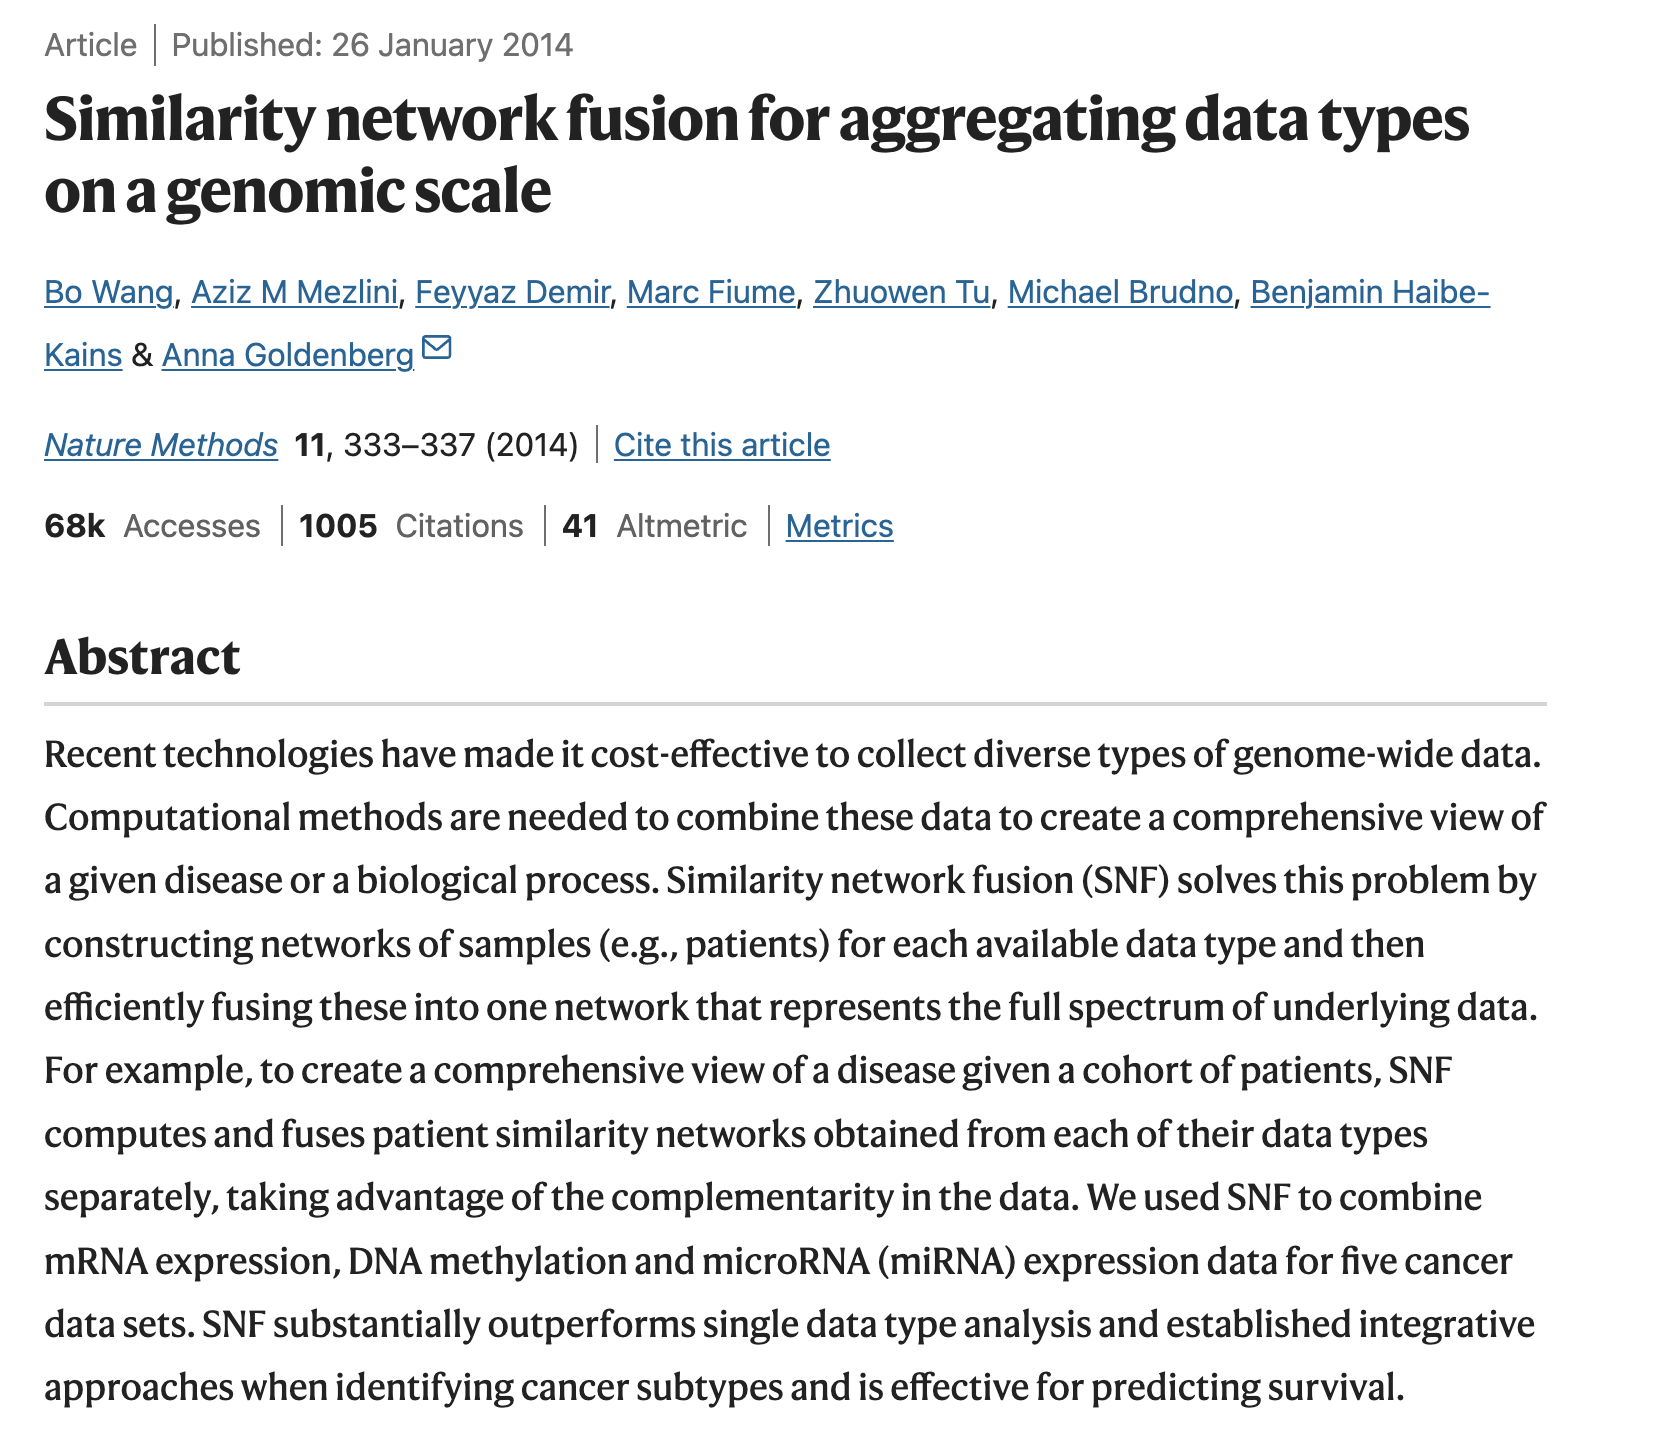

### 1. Overview
Biomedical data such as gene expression, methylation, and mutation data are heterogeneous. 
To capture complex relationships, SNF constructs a fused network that integrates all sources.

**Input**: Multiple omics datasets

**Process**: Steps involved in similarity network fusion are as follows: 
1. Build similarity network from each dataset
2. Iterative message passing
3. Fused network

**Output**: Unified patient similarity graph

### 2. Mathematical background

### Step 1: Similarity Matrix
$$ W_{ij} = \exp\left(-\frac{\|x_i - x_j\|^2}{\mu}\right) $$
Only retain $K$ nearest neighbors.

### Step 2: SNF Iterative Update
$$ W_i^{(t+1)} = P_i \left(\sum_{j \ne i} W_j^{(t)}\right) P_i^\top $$
Where $P_i$ is a row-normalized transition matrix.

### Step 3: Spectral Clustering
$$ L = D - W $$
Apply k-means on the eigenvectors of $L$ and $D$ is the diagonal matrix.


originally proposed in https://www.nature.com/articles/nmeth.2810 

### 3. Similarity Network Fusion usng SNFpy python Package. 

If you have not installed snfpy, please use following command:

!pip install snfpy

More details: https://github.com/rmarkello/snfpy 

#### Demonstrating the fusion using randomly generated data points. 

Lets us generate 3 dataframes: 
1. First one to simulate transcriptomics
2. Second one to simulate Genomics/mutations
3. Third one is to simulate epigenomics/Methylation.

In [ ]:
import numpy as np
from snf import make_affinity, snf, compute
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:

np.random.seed(0)

In [ ]:
# Simulating three types of omics data (e.g., expression, methylation, mutation)
#np.random.seed(42)  # for reproducibility

# 100 samples (patients), 500 gene expression features
X1 = np.random.rand(100, 500)  

# 100 samples, 300 methylation features
X2 = np.random.rand(100, 300)

# 100 samples, 200 mutation features
X3 = np.random.rand(100, 200)

#### Let's scale the data points centered around the mean

In [ ]:
scaler = StandardScaler()

X1_scaled = scaler.fit_transform(X1)
X2_scaled = scaler.fit_transform(X2)
X3_scaled = scaler.fit_transform(X3)

#### Next step is to make similarity network for each individual omics data. 

The scaled exponential similarity kernel, based on the probability density
function of the normal distribution, takes the form:

 
$\mathbf{W}(i, j) = \frac{1}{\sqrt{2\pi\sigma^2}}$
                          $\ exp^{-\frac{\rho^2(x_{i},x_{j})}{2\sigma^2}}$

where $\rho(x_{i},x_{j})$ is the Euclidean distance (or other distance metric, as appropriate) between patients $x_{i}$ and $x_{j}$. The value for $\\sigma$ is calculated as:

$\sigma = \mu\ \frac{\overline{\rho}(x_{i},N_{i})+ \overline{\rho}(x_{j},N_{j}) + \rho(x_{i},x_{j})}{3} $

where $\overline{\rho}(x_{i},N_{i})$ represents the average value of distances between $x_{i}$ and its neighbors $N_{1..K}$, and $\mu\in(0, 1)\subset\mathbb{R}$.

In [ ]:
aff1 = make_affinity(X1_scaled, K=20, mu=0.5)
aff2 = make_affinity(X2_scaled, K=20, mu=0.5)
aff3 = make_affinity(X3_scaled, K=20, mu=0.5)

In [ ]:
X1_scaled.shape 

In [ ]:
aff1.shape 

In [ ]:
aff2.shape

In [ ]:
aff3.shape

In [ ]:
aff1==aff2 

#### Fusing the graphs

In order to fuse the supplied $m$ arrays, each must be normalized. Atraditional normalization on an affinity matrix would suffer from numerical instabilities due to the self-similarity along the diagonal; thus, a modified normalization is used:


$\mathbf{P}(i,j) =\left\{\begin{array}{rr}\frac{\mathbf{W}_(i,j)} {2 \sum_{k\neq i}^{} \mathbf{W}_(i,k)} ,& j \neq i \\1/2 ,& j = i \end{array}\right.$

Under the assumption that local similarities are more important than distant ones, a more sparse weight matrix is calculated based on a KNN framework.
$\mathbf{S}(i,j) = \left\{\begin{array}{rr} \frac{\mathbf{W}_(i,j)} {\sum_{k\in N_{i}}^{}\mathbf{W}_(i,k)} ,& j \in N_{i} \\ 0 ,& \text{otherwise} \end{array}\right.$

The two weight matrices $\mathbf{P}$ and $\mathbf{S}$ thus provide information about a given patient's similarity to all other patients and the `K` most similar patients, respectively.
These :math:`m` matrices are then iteratively fused. At each iteration, the matrices are made more similar to each other via:
$\mathbf{P}^{(v)} = \mathbf{S}^{(v)} \times \frac{\sum_{k\neq v}^{}\mathbf{P}^{(k)}}{m-1} \times (\mathbf{S}^{(v)})^{T}, v = 1, 2, ..., m $

After each iteration, the resultant matrices are normalized via the equation above. Fusion stops after `t` iterations, or when the matrices $\mathbf{P}^{(v)}, v = 1, 2, ..., m$ converge.

The output fused matrix is full rank and can be subjected to clustering and classification.

In [ ]:
fused_network = snf([aff1, aff2, aff3], K=20, t=20)

In [ ]:
fused_network.shape

#### Clustering

In [ ]:
from sklearn.cluster import spectral_clustering
n_clusters = 3
labels = spectral_clustering(fused_network, n_clusters=n_clusters)

In [ ]:
labels

#### Listing marker features. 

In [ ]:
from scipy.stats import f_oneway

# Example: gene_expression is a (samples x genes) DataFrame
significant_genes = []

for gene in range(X1.shape[1]):
    groups = [X1[labels == i][:,gene] for i in range(n_clusters)]
    fval, pval = f_oneway(*groups)
    if pval < 0.01:
        significant_genes.append((gene, pval))

# Sort by p-value
biomarkers = sorted(significant_genes, key=lambda x: x[1])

In [ ]:
biomarkers

#### 4. Case Study : Applying  similarity graph based fusion to CLL datasets to find biomarkers (e.g., differentially expressed genes).

In [ ]:
data_loc = ""
df_meth = pd.read_csv(data_loc + "CLL_data_Methylation.csv", index_col=0)
df_mrna = pd.read_csv(data_loc + "CLL_data_mRNA.csv", index_col=0)
df_mut = pd.read_csv(data_loc + "CLL_Mutations.txt", sep='\t', index_col=0)

In [ ]:
df_meth

In [ ]:
df_mrna

In [ ]:
df_mut

In [ ]:
# drop nans by column
df_mrna = df_mrna.dropna(axis='columns')
df_meth = df_meth.dropna(axis='columns')
df_mut = df_mut.dropna(axis='columns')

In [ ]:
df_meth

In [ ]:
df_mrna

In [ ]:
df_mut

In [ ]:
df_mrna = df_mrna.T
df_meth = df_meth.T

In [ ]:
df_meth

In [ ]:
df_mrna

In [ ]:
df_meth

In [ ]:

cols = df_meth.columns.copy()
columns = {}
for c in cols:
    mask = df_meth[c] < 0
    columns[c + '_p'] = df_meth[c].mask(mask)
    columns[c + '_n'] = - df_meth[c].mask(~mask)





In [ ]:
df_meth = pd.concat(list(columns.values()), keys=list(columns.keys()), axis=1)  
df_meth = df_meth.fillna(0)

In [ ]:
df_meth

In [ ]:
X = pd.concat([df_mrna.T, df_meth.T])
X = X.dropna(axis='columns')
print(X.shape)

In [ ]:
X

In [ ]:
X1 = X.iloc[5000:, :].T
X2 = X.iloc[:5000, :].T

In [ ]:
X1

In [ ]:
X2

In [ ]:
graph_meth=make_affinity(X1, metric='euclidean', K=20, mu=0.5)

In [ ]:
graph_meth.shape

In [ ]:
graph_mrna=make_affinity(X2, metric='euclidean', K=20, mu=0.5)
graph_mrna.shape

In [ ]:
graph_fusion=snf([graph_meth, graph_mrna], K=20, t=20)

In [ ]:
graph_fusion

In [ ]:
graph_fusion.shape 

In [ ]:
node_ids=list(X2.index)
node_ids 

In [ ]:
first, second = compute.get_n_clusters(graph_fusion)
first, second

In [ ]:
from sklearn.cluster import spectral_clustering
n_clusters = first
labels = spectral_clustering(graph_fusion, n_clusters=n_clusters)

In [ ]:
X2.columns

In [ ]:
labels

In [ ]:
len(labels)

In [ ]:

from scipy.stats import f_oneway

# Example: gene_expression is a (samples x genes) DataFrame
significant_genes = []

for gene in X2.columns:
    groups = [X2[labels == i][gene] for i in range(n_clusters)]
    
    fval, pval = f_oneway(*groups)
    if pval < 0.01:
        significant_genes.append((gene, pval))

# Sort by p-value
biomarkers = sorted(significant_genes, key=lambda x: x[1])


In [ ]:
x=[x[0] for x in biomarkers[:10]]

print(x)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

top_genes = [g[0] for g in biomarkers[:10]]
data = X2[top_genes]
data['Cluster'] = labels

# Melt for seaborn boxplot
melted = pd.melt(data, id_vars='Cluster', value_vars=top_genes)

plt.figure(figsize=(12, 6))
sns.boxplot(x="variable", y="value", hue="Cluster", data=melted)
plt.xticks(rotation=45)
plt.title("Top Biomarkers by Cluster")
plt.tight_layout()
plt.show()
